In [1]:
import torch
from torch import nn

import numpy as np

from qiskit import QuantumCircuit, transpile
from qiskit.quantum_info import Operator
from qiskit.visualization import plot_histogram

from qiskit_aer import AerSimulator
from qiskit_ibm_runtime.fake_provider import FakeAthensV2

import pennylane as qml

import matplotlib.pyplot as plt

from random import shuffle
from tqdm import tqdm

In [2]:
import sys
sys.path.append('../')

In [3]:
from circuits.generate_circuits import custom_ghz
from circuits.modify_circuits import append_pqc_to_quantum_circuit, get_circuit_for_model, get_unitary_for_model_pennylane
from circuits.pqc_circuits import pennylane_PQC_RZRXRZ_unique, qiskit_PQC_RZRXRZ_unique, qiskit_PQC_RXRZ_unique

from simulator.simulate import get_ideal_data_state, get_ideal_data_superpos
from models.pennylane_models import SimplePennylaneQuantumStateModel
from models.noise_models import BitPhaseFlipNoise
from circuits.generate_circuits import GetGHZCircuitsForModel
from utils.loss_functions import QuantumFidelityLoss

In [4]:
if torch.mps.is_available():
    print('Torch running on Apple GPU')
    torch_device = torch.device("mps")
    aer_device = "CPU"
elif torch.cuda.is_available():
    print('Torch running on Nvidia GPU')
    torch_device = torch.device("cuda")
    aer_device = "GPU"
else:
    print('Torch running on CPU')
    torch_device = torch.device("cpu")
    aer_device = "CPU"


Torch running on Nvidia GPU


In [13]:
NUM_SHOTS = 2**10
NUM_QUBITS = 10
H_ON = 3
INPUT_BITS = '1010100110'
EPOCHS = 5
# fakeVigo2_backend = FakeVigoV2()
# fakeAthensV2_backend = FakeAthensV2()

ideal_sim = AerSimulator()
# noisy_sim = AerSimulator().from_backend(fakeAthensV2_backend)
pqc_arch = pennylane_PQC_RZRXRZ_unique

In [6]:
noise_model = BitPhaseFlipNoise()

pqc_model = SimplePennylaneQuantumStateModel(
    num_qubits= NUM_QUBITS, num_params=NUM_QUBITS*3, pqc_arch_func=pqc_arch,   
    )

ghz_circuit_gen = GetGHZCircuitsForModel(
    num_qubits= NUM_QUBITS, hammard_on=H_ON, noise=noise_model
    )



In [7]:
optimizer = torch.optim.AdamW(pqc_model.parameters(), lr=0.05)
loss_fn = QuantumFidelityLoss()
# loss_fn = nn.MSELoss()

In [8]:
ideal_data = get_ideal_data_state(NUM_QUBITS, num_vals=int(10000))
# get_ideal_data(NUM_QUBITS, NUM_SHOTS, num_values=1000, get_soft=False)
print(len(ideal_data[10][1]))

Generating Ideal Data: 100%|██████████| 10000/10000 [00:16<00:00, 591.72it/s]

1024


In [9]:
param_list_epoch = []  # Stores parameter evolution across epochs
loss_list_epoch = []   # Stores mean loss per epoch

enable_debug_logs = True  # Set False to suppress grad/param printouts
lambda_reg = 0.01         # Regularization weight

for epoch in range(EPOCHS):
    print(f'\n Starting Epoch {epoch+1}')
    pqc_model.train()
    epoch_loss_list = []
    epoch_param_snapshots = []

    shuffle(ideal_data)
    data_iterator = tqdm(ideal_data)

    for step, (params, ideal) in enumerate(data_iterator):
        optimizer.zero_grad()

        circuit = ghz_circuit_gen.get_noisy_model_circuit_params(params)
        measured = pqc_model(circuit=circuit)

        ideal = ideal.to(torch_device)
        measured = measured.to(torch_device)

        # print(ideal)
        # print(measured)

        # Compute fidelity loss
        # print(ideal)
        # print(measured)
        loss = loss_fn(ideal, measured)

        # Add optional regularization to keep angles from zeroing out

        loss.backward()
        optimizer.step()

        raw_param_values = pqc_model.raw_params.detach().cpu().numpy()
        epoch_param_snapshots.append(raw_param_values)
        epoch_loss_list.append(loss.item())

        data_iterator.set_postfix_str(f"Loss: {loss.item():.4e}")

        # Optional: print debug stats
        if enable_debug_logs and step == 0:
            grad_norm = pqc_model.raw_params.grad.norm().item()
            # bounded = pqc_model.raw_params.detach().cpu().numpy()
            print(f"\tStep {step}, grad norm: {grad_norm:.4e}")
            print(f"\tRaw param range: [{raw_param_values.min():.3f}, {raw_param_values.max():.3f}]")
            # print(f"\tBounded param range: [{bounded.min():.3f}, {bounded.max():.3f}]")

# Optional: print debug stats
        # if enable_debug_logs and step == len(data_iterator) - 1:
        #     print(circuit.draw())
        #     print(measured)
        #     print(ideal)
        #     print(loss)

    # Log epoch summary
    avg_loss = np.mean(epoch_loss_list)
    loss_list_epoch.append(avg_loss)
    param_list_epoch.extend(np.array(epoch_param_snapshots))

    print(f"Epoch {epoch+1} complete: avg loss = {avg_loss:.4e}")

        


 Starting Epoch 1


  0%|          | 1/10000 [00:01<3:11:35,  1.15s/it, Loss: 9.9999e-01]

	Step 0, grad norm: 1.0737e-04
	Raw param range: [-8.971, 8.305]


100%|██████████| 10000/10000 [1:46:00<00:00,  1.57it/s, Loss: 7.7183e-02]


Epoch 1 complete: avg loss = 9.9429e-02

 Starting Epoch 2


  0%|          | 1/10000 [00:00<1:42:54,  1.62it/s, Loss: 9.5059e-02]

	Step 0, grad norm: 1.0646e-01
	Raw param range: [-8.453, 9.251]


100%|██████████| 10000/10000 [1:49:54<00:00,  1.52it/s, Loss: 6.4049e-02]


Epoch 2 complete: avg loss = 9.3555e-02

 Starting Epoch 3


  0%|          | 1/10000 [00:00<1:51:05,  1.50it/s, Loss: 1.9793e-01]

	Step 0, grad norm: 1.0557e-01
	Raw param range: [-8.384, 9.174]


100%|██████████| 10000/10000 [1:50:40<00:00,  1.51it/s, Loss: 1.0726e-01]


Epoch 3 complete: avg loss = 9.3779e-02

 Starting Epoch 4


  0%|          | 1/10000 [00:00<1:36:31,  1.73it/s, Loss: 8.7566e-02]

	Step 0, grad norm: 1.1294e-01
	Raw param range: [-8.389, 9.120]


100%|██████████| 10000/10000 [1:51:49<00:00,  1.49it/s, Loss: 5.6749e-02]


Epoch 4 complete: avg loss = 9.3696e-02

 Starting Epoch 5


  0%|          | 1/10000 [00:00<1:52:28,  1.48it/s, Loss: 1.2061e-01]

	Step 0, grad norm: 1.5567e-01
	Raw param range: [-8.359, 9.160]


100%|██████████| 10000/10000 [1:47:16<00:00,  1.55it/s, Loss: 9.0429e-02]

Epoch 5 complete: avg loss = 9.4082e-02


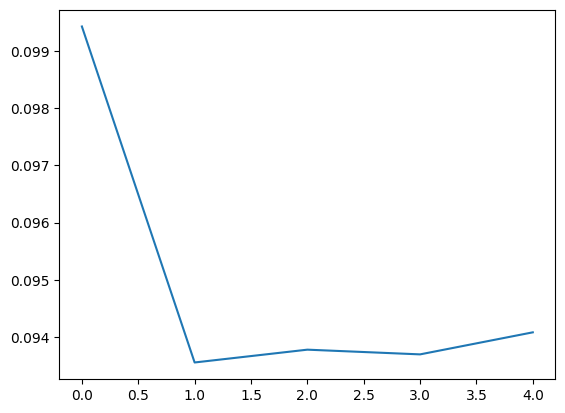

In [10]:
plt.plot(range(EPOCHS), loss_list_epoch)
plt.show()

In [11]:
print(pqc_model.raw_params)

Parameter containing:
tensor([-0.2003, -6.4749, -6.2449,  6.1880, -6.4928,  6.2155, -6.2618, -0.2430,
        -0.1672, -6.5435, -8.5192,  6.1496,  0.0316, -0.2162,  6.1207, -6.3320,
         6.0421, -6.3573, -6.1809,  6.0826,  5.9923, -3.0193,  0.2209,  9.1167,
         5.9778, -0.2086, -6.1334, -3.0851,  6.4600,  3.0423],
       requires_grad=True)


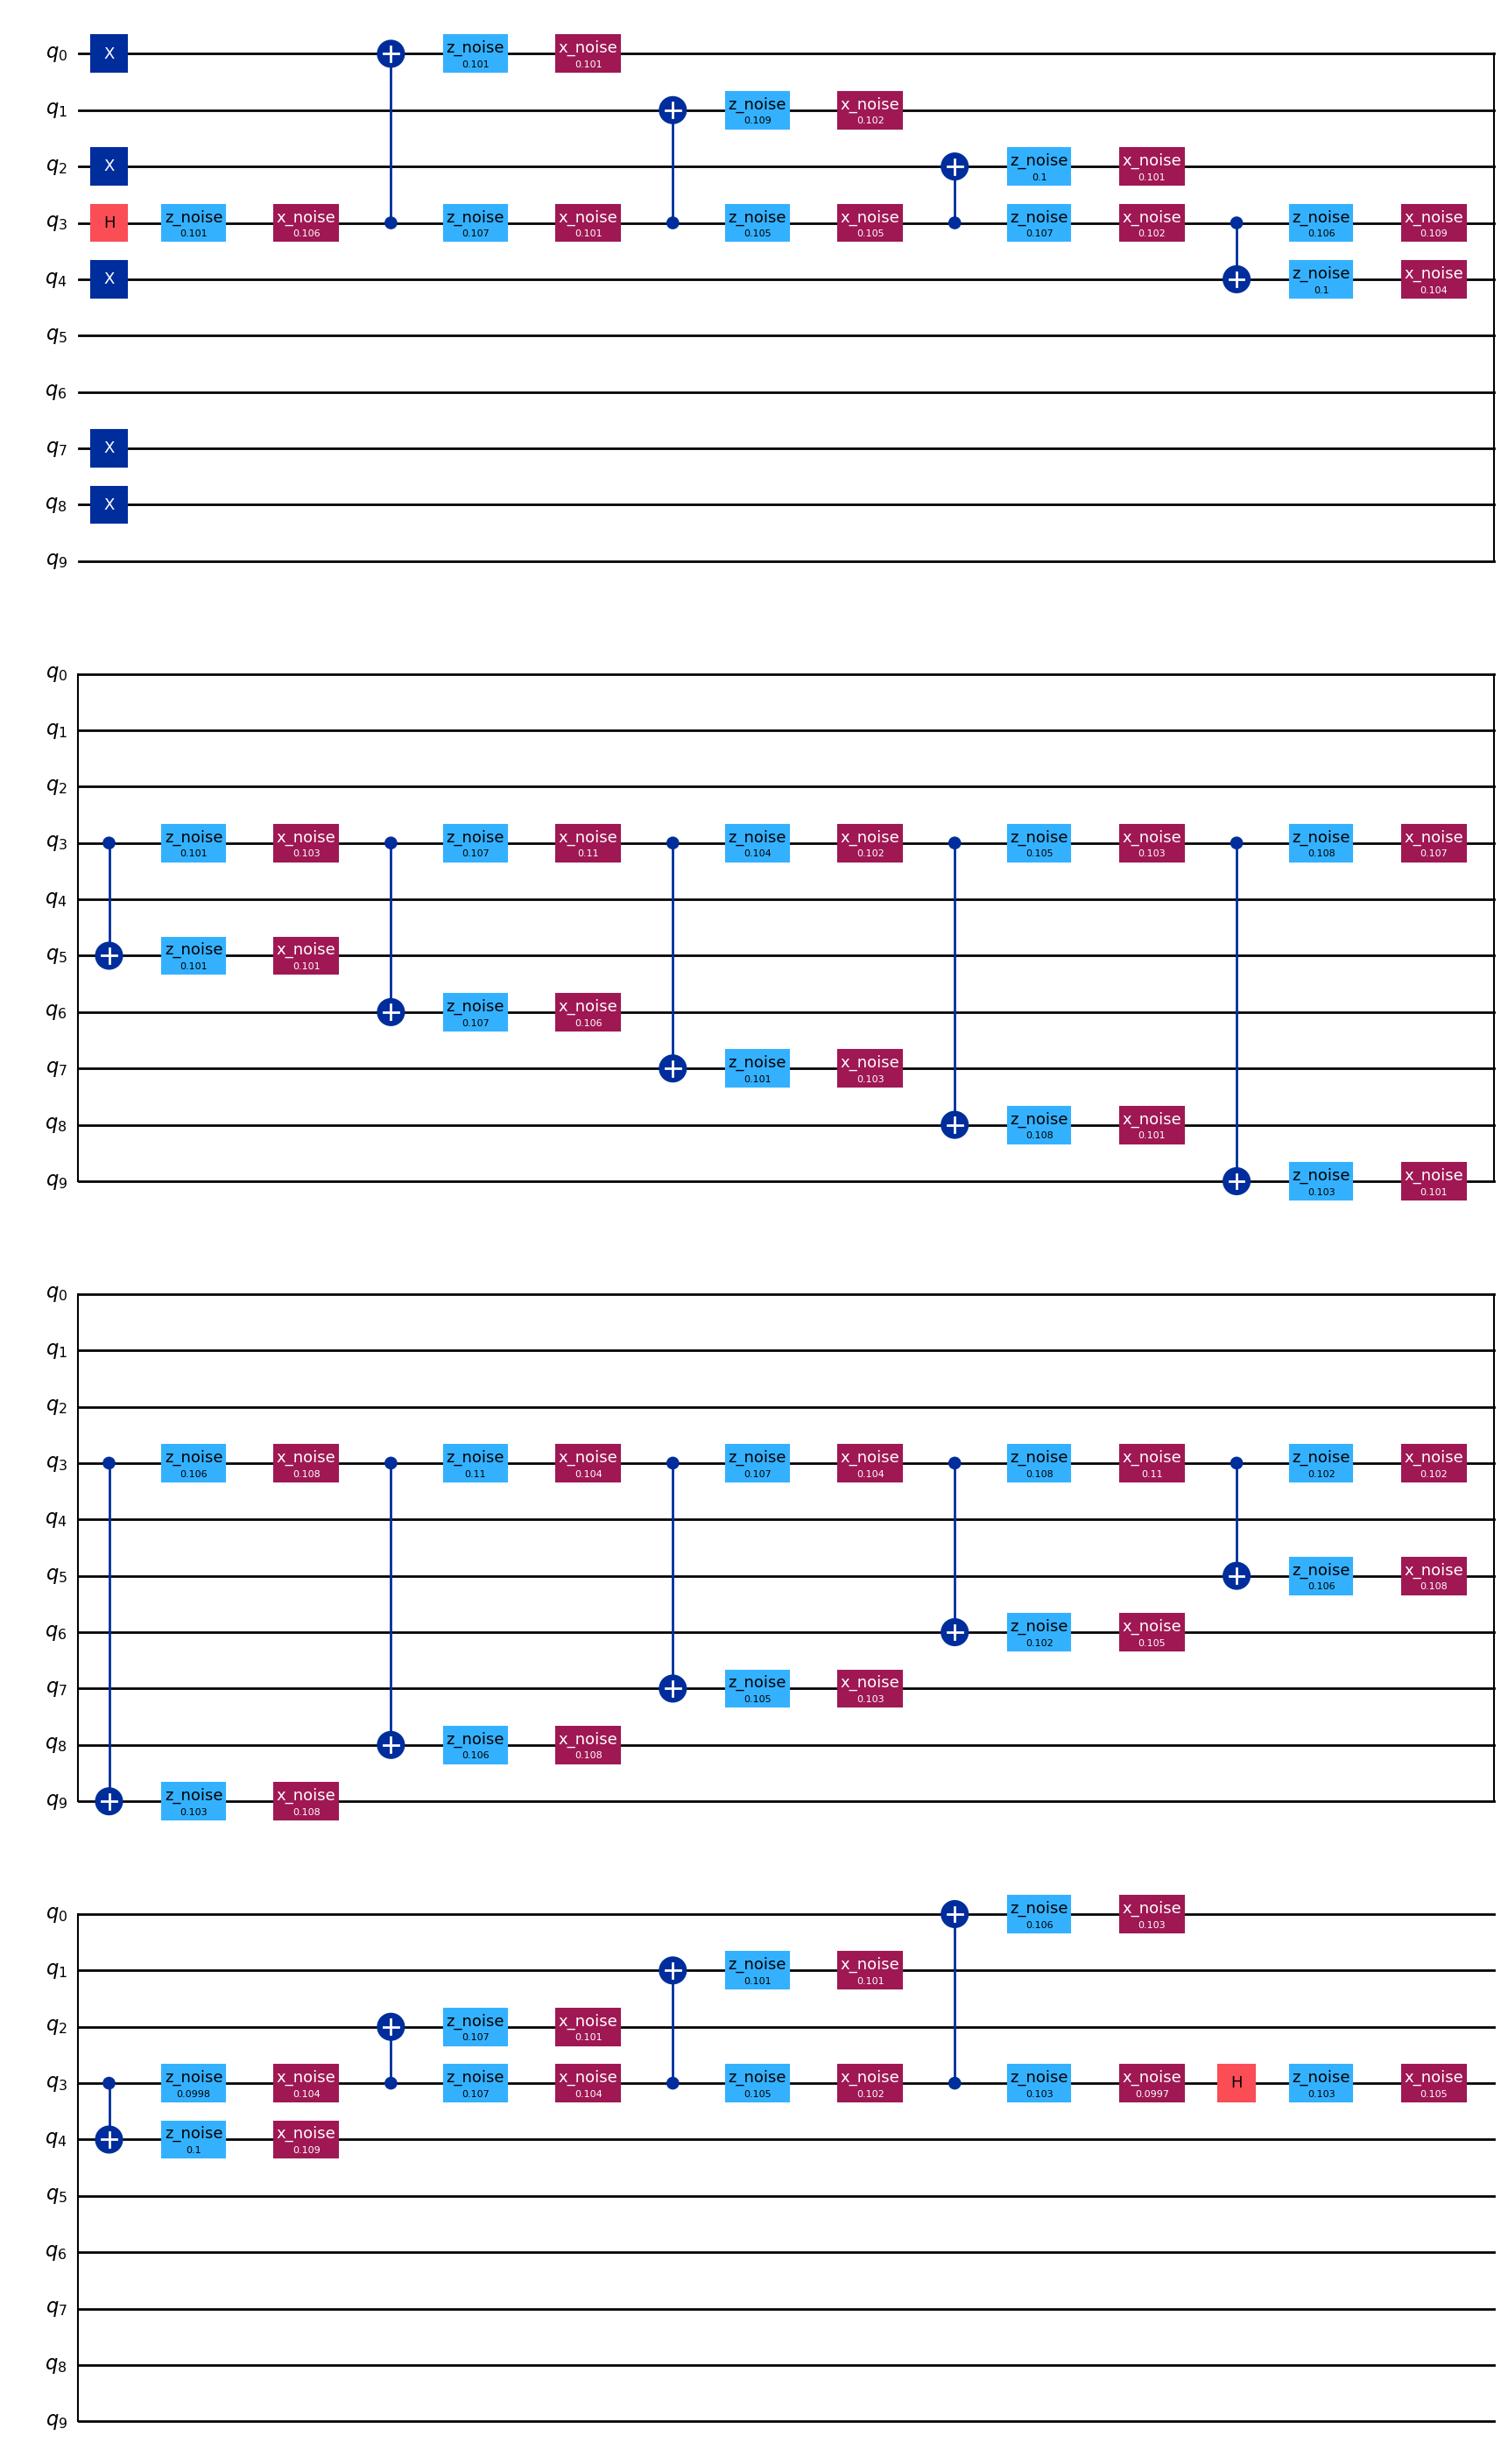

In [14]:
noisy_model_circ = ghz_circuit_gen.get_noisy_model_circuit_bitstring(INPUT_BITS)
noisy_model_circ.draw('mpl')

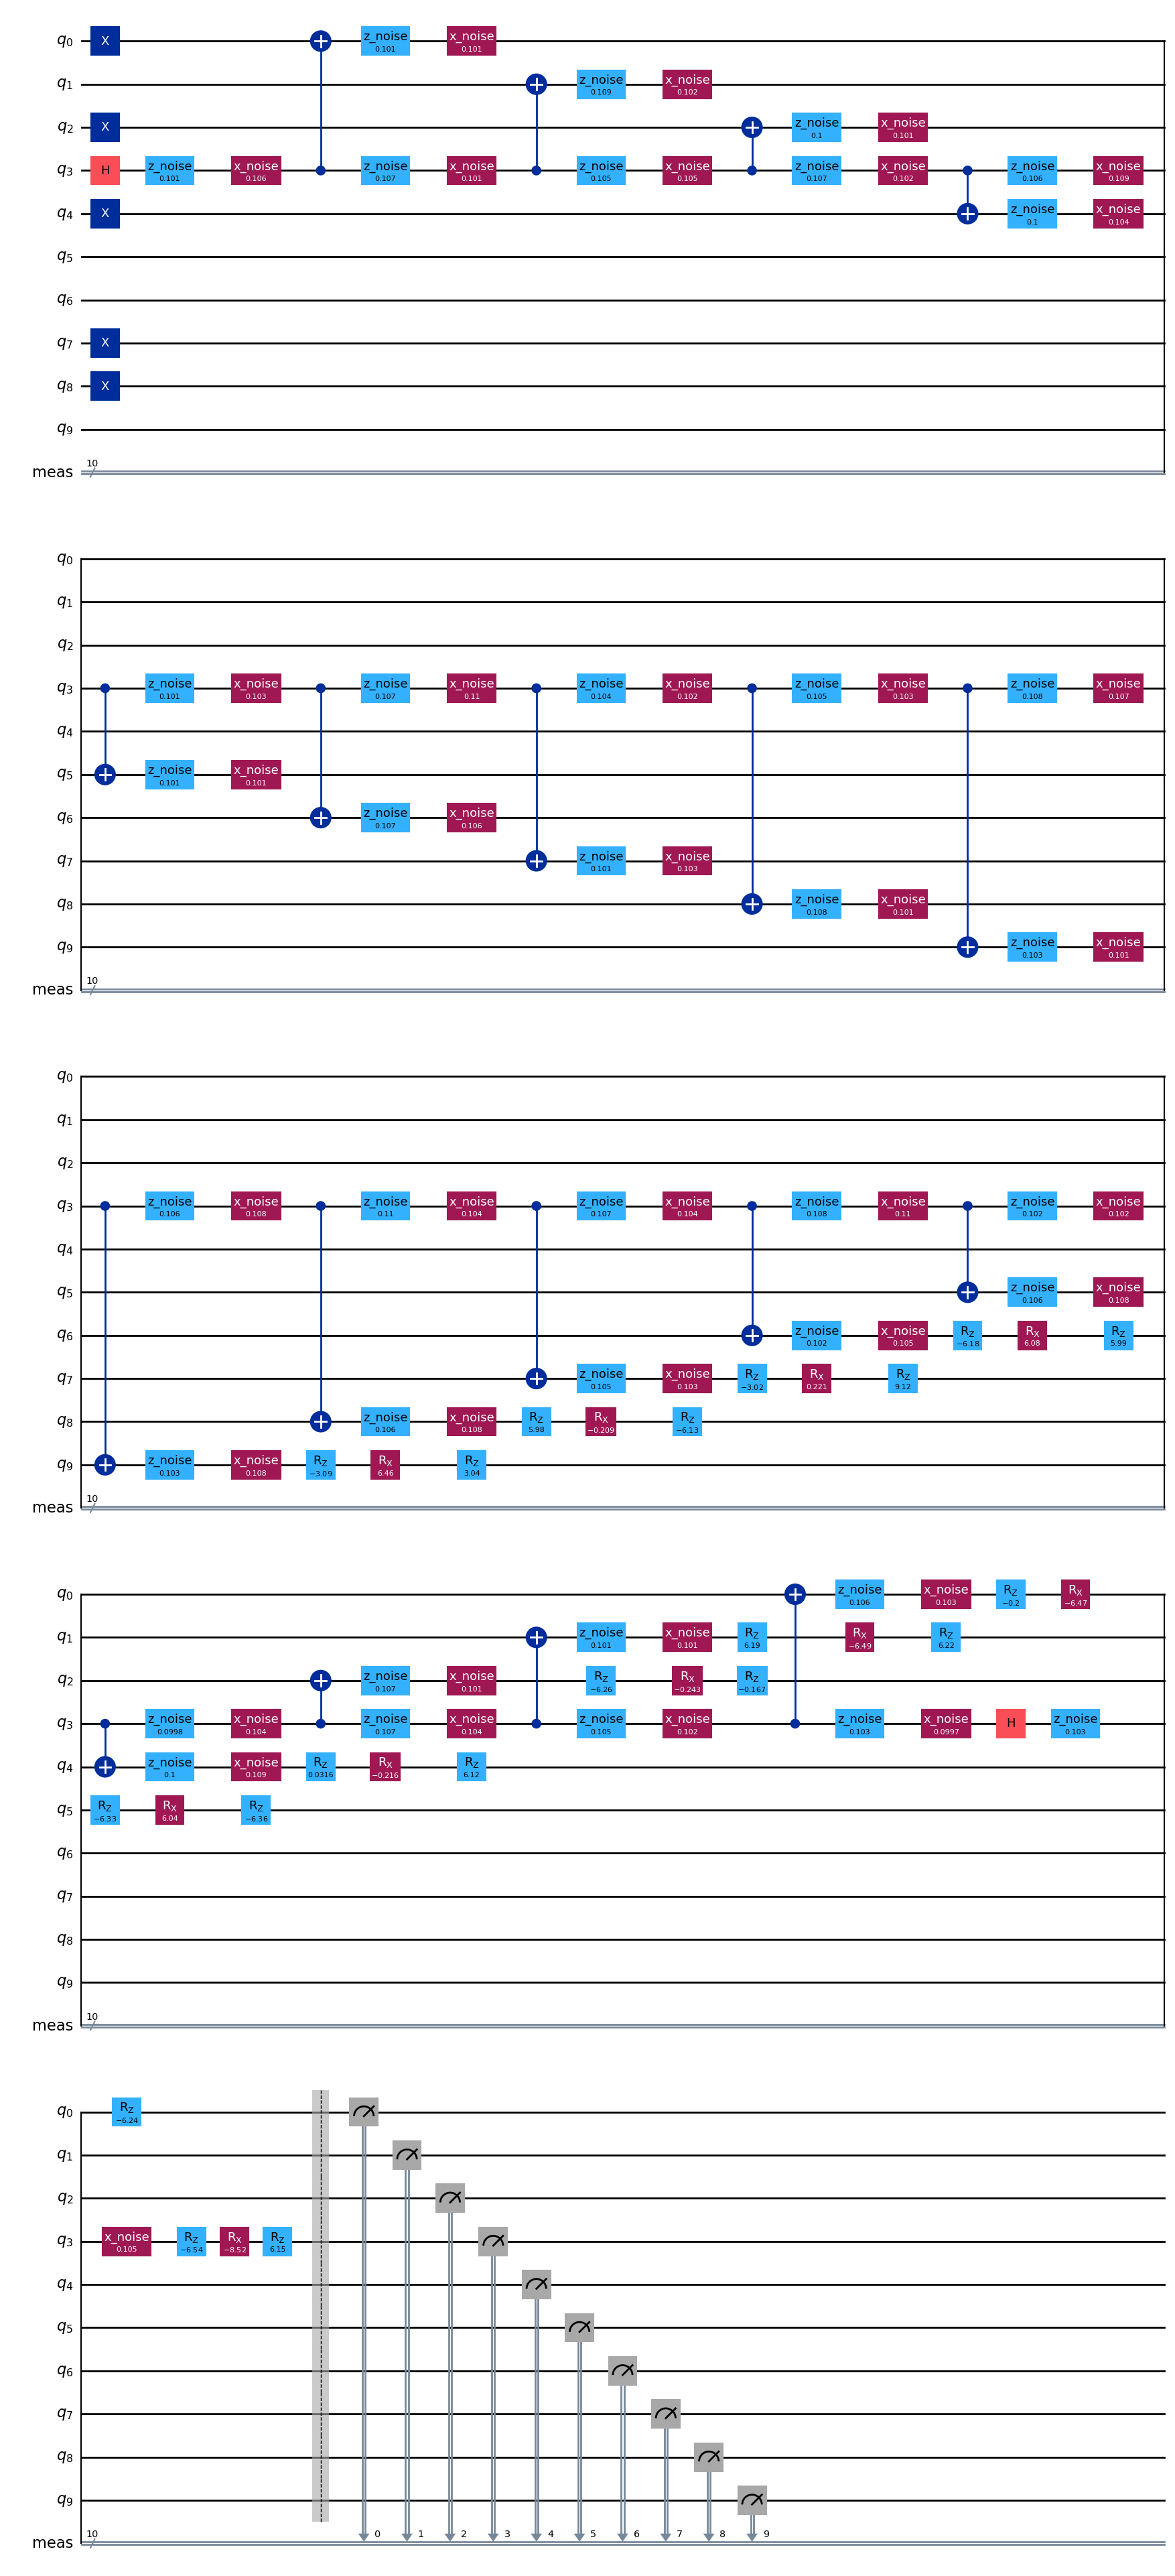

In [15]:
noisy_model_circ_pqc = append_pqc_to_quantum_circuit(noisy_model_circ, pqc_model.raw_params, qiskit_PQC_RZRXRZ_unique)
noisy_model_circ_pqc.draw('mpl')

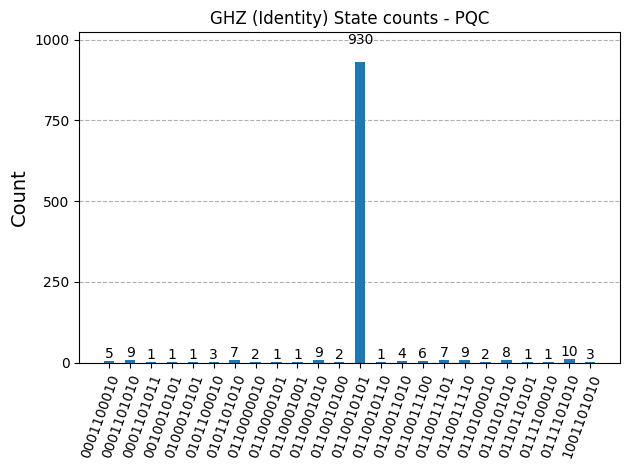

In [16]:
transpiled_circ = transpile(noisy_model_circ_pqc, ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - PQC')

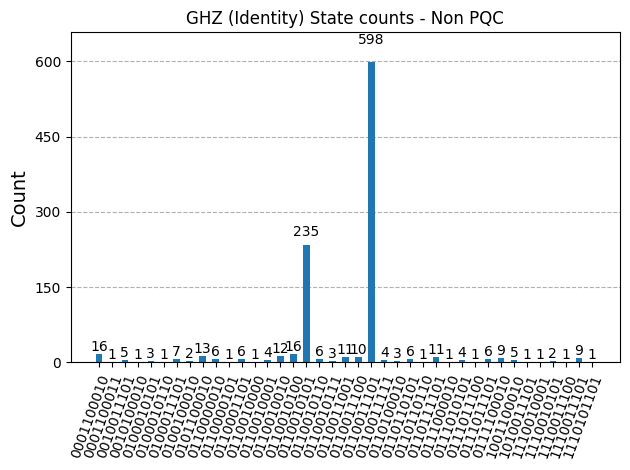

In [17]:
transpiled_circ = transpile(noisy_model_circ.measure_all(inplace=False), ideal_sim)
result = ideal_sim.run(transpiled_circ, shots=NUM_SHOTS).result()
counts = result.get_counts(transpiled_circ)

plot_histogram(counts, title='GHZ (Identity) State counts - Non PQC')

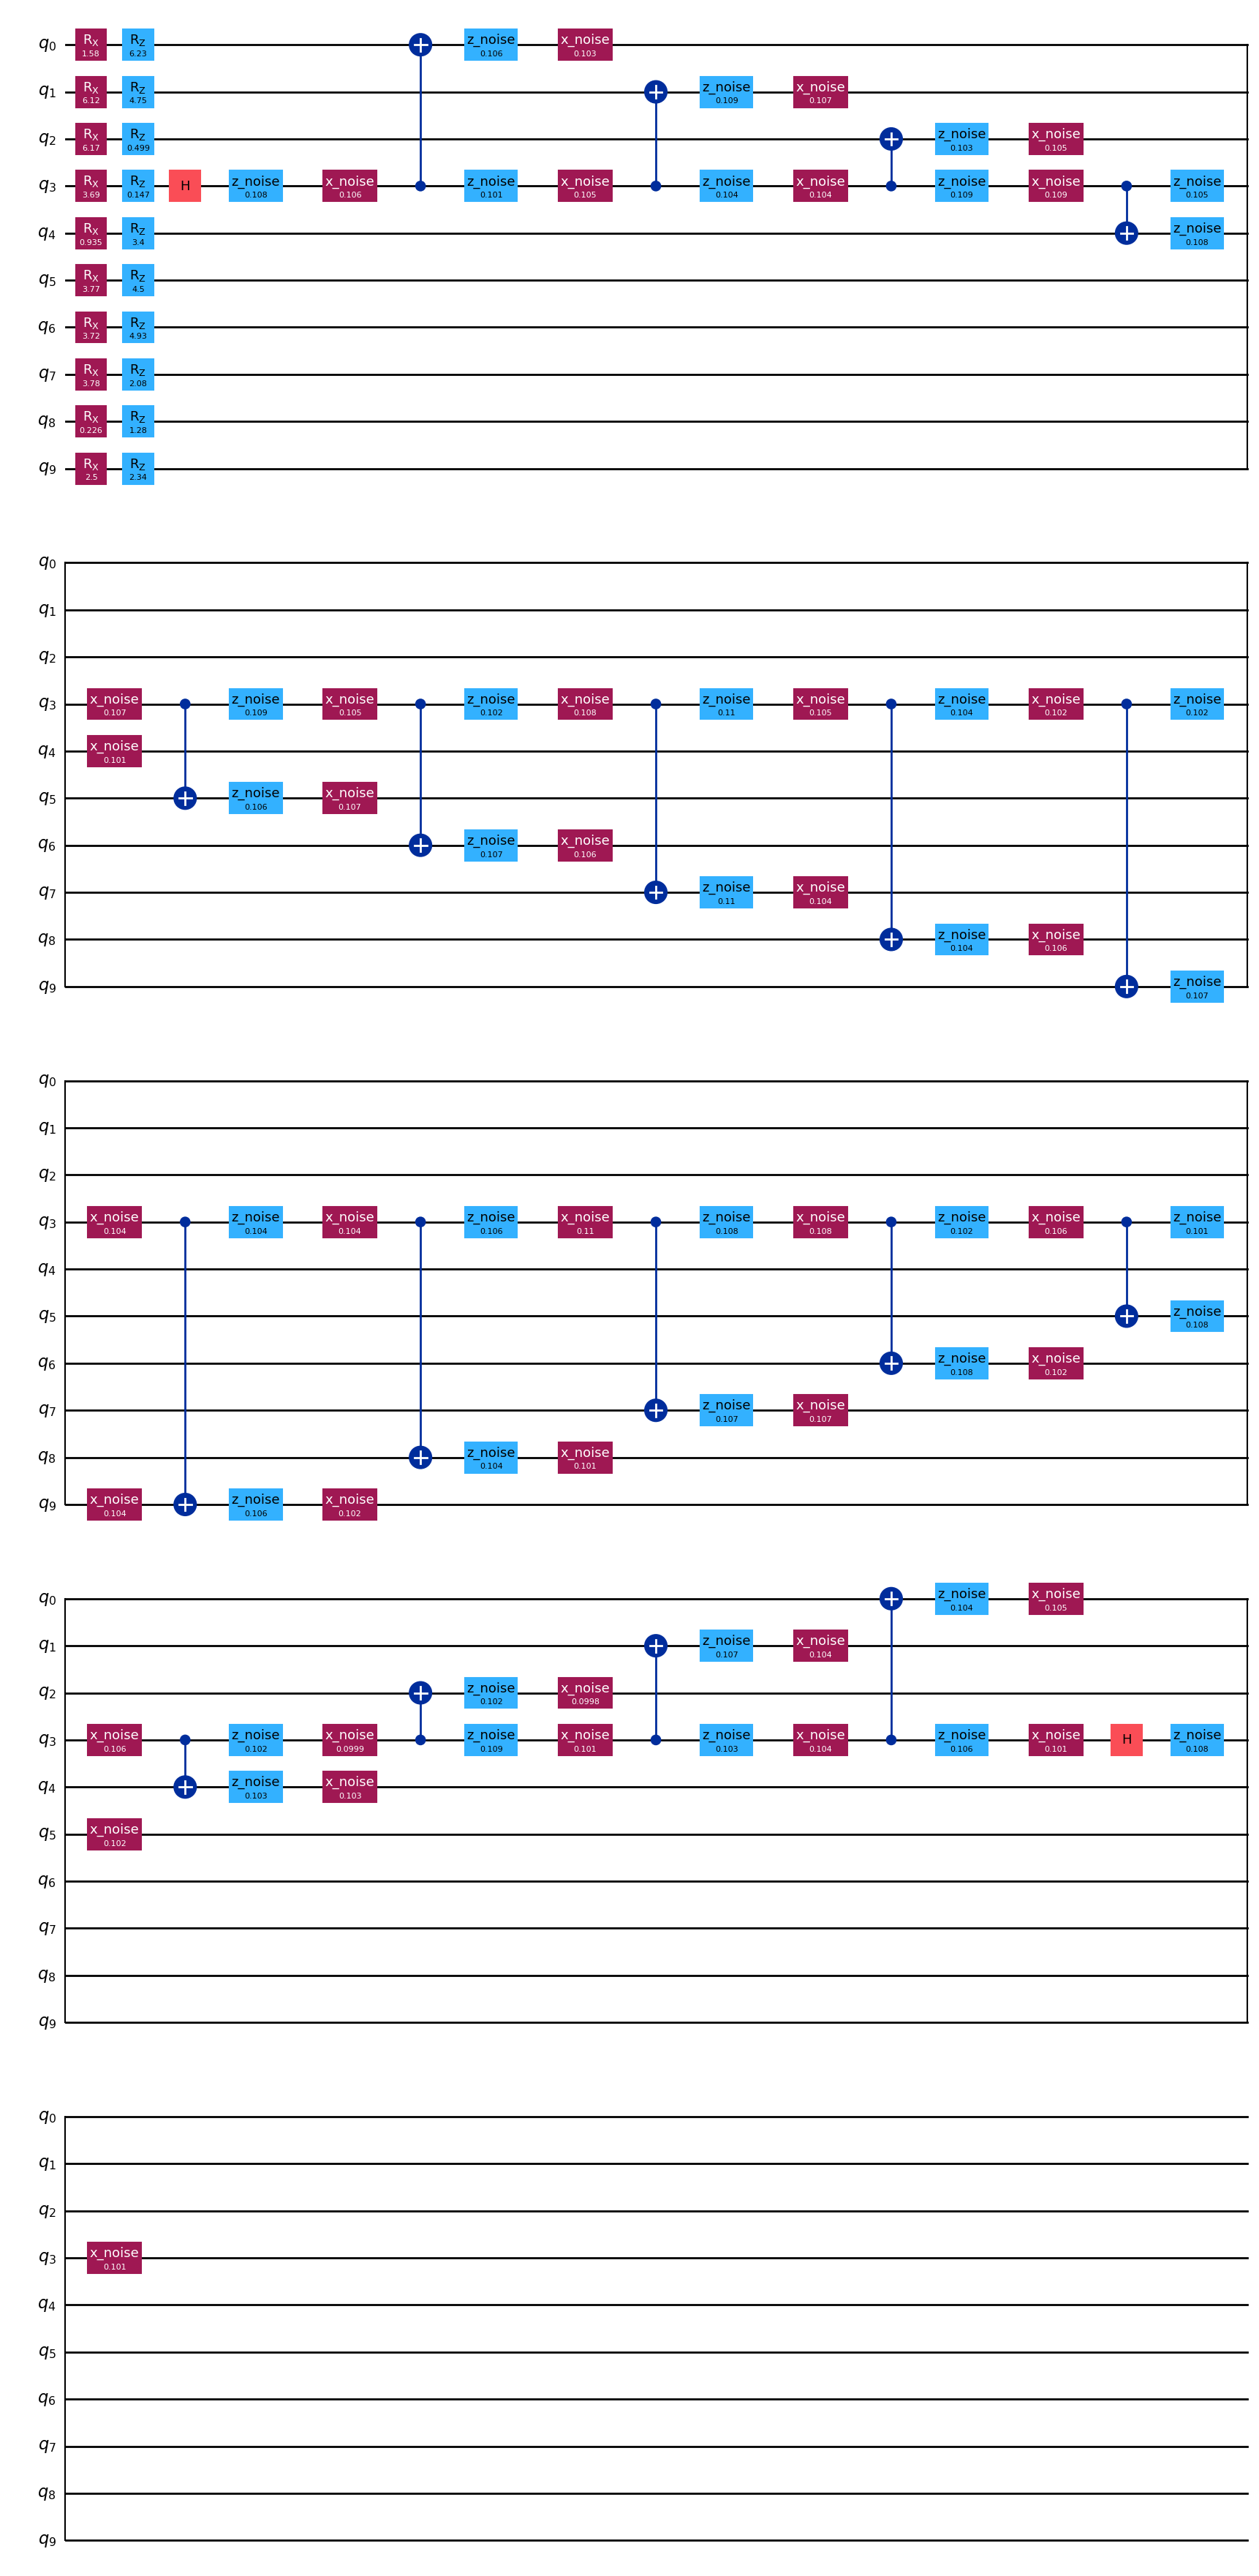

In [18]:
circuit.draw('mpl')

In [19]:
from qiskit.quantum_info import Statevector

def counts_to_probs(counts: torch.Tensor) -> torch.Tensor:
    """Convert integer counts to a normalized probability vector."""
    return counts.float() / counts.sum()

def state_fidelity(psi: torch.Tensor, phi: torch.Tensor) -> torch.Tensor:
    """
    Compute fidelity F = |⟨ψ|φ⟩|² between two normalized state vectors.

    Args:
        psi (torch.Tensor): Complex tensor of shape (2**n,) representing |ψ⟩
        phi (torch.Tensor): Complex tensor of shape (2**n,) representing |φ⟩

    Returns:
        torch.Tensor: Real-valued scalar fidelity
    """
    # Optional: normalize if needed
    psi = psi / torch.linalg.norm(psi)
    phi = phi / torch.linalg.norm(phi)

    overlap = torch.dot(torch.conj(psi), phi)
    return torch.abs(overlap) ** 2

fid_noisy = []
fid_noisy_pqc = []

pqc_params = pqc_model.raw_params

ideal_data_test = get_ideal_data_superpos(NUM_QUBITS, num_vals=20, statevector=True)

for param, ideal in ideal_data_test:
    noisy_circ = ghz_circuit_gen.get_noisy_model_circuit_params(params=param)
    noisy_circ_pqc = append_pqc_to_quantum_circuit(noisy_circ, pqc_params, qiskit_PQC_RZRXRZ_unique)

    # counts_noisy = run_circuit_sampler(noisy_circ.measure_all(inplace=False))
    # counts_noisy_pqc = run_circuit_sampler(noisy_circ_pqc)

    # prob_i = counts_to_probs(ideal)
    # prob_n = counts_to_probs(counts_noisy)
    # prob_ne = counts_to_probs(counts_noisy_pqc)
    noi_out_st = torch.tensor(Statevector.from_instruction(noisy_circ.remove_final_measurements(inplace=False)).data)
    npqc_out_st = torch.tensor(Statevector.from_instruction(noisy_circ_pqc.remove_final_measurements(inplace=False)).data)
    
    

    fid_i_n = state_fidelity(ideal, noi_out_st)
    fid_i_ne = state_fidelity(ideal, npqc_out_st)

    fid_noisy.append(fid_i_n)
    fid_noisy_pqc.append(fid_i_ne)

    

Generating Ideal Data: 100%|██████████| 20/20 [00:00<00:00, 1141.26it/s]


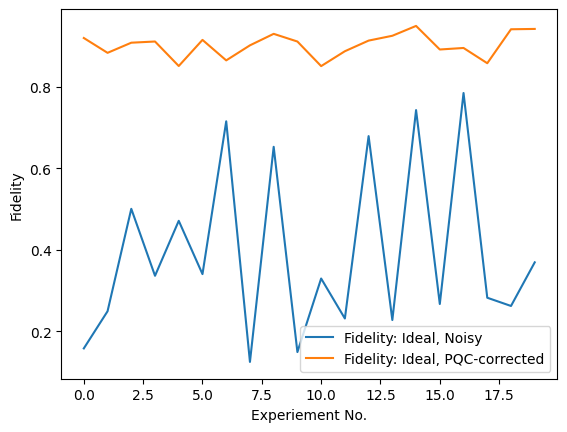

In [20]:
x = range(len(ideal_data_test))

# option 1 ─ two explicit calls
plt.plot(x, fid_noisy,      label='Fidelity: Ideal, Noisy')
plt.plot(x, fid_noisy_pqc,  label='Fidelity: Ideal, PQC-corrected')
plt.xlabel('Experiement No.')          # optional cosmetics
plt.ylabel('Fidelity')
plt.legend()                      # shows the two labels
plt.show()

In [21]:
print(f"Avg Fidelity of noisy circuit: {np.mean(fid_noisy)}, Average Fidelity of noisy circ with PQC: {np.mean(fid_noisy_pqc)}")

Avg Fidelity of noisy circuit: 0.39374625991242784, Average Fidelity of noisy circ with PQC: 0.9021289647648896


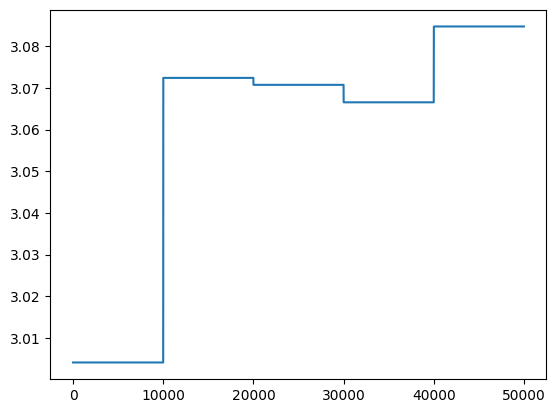

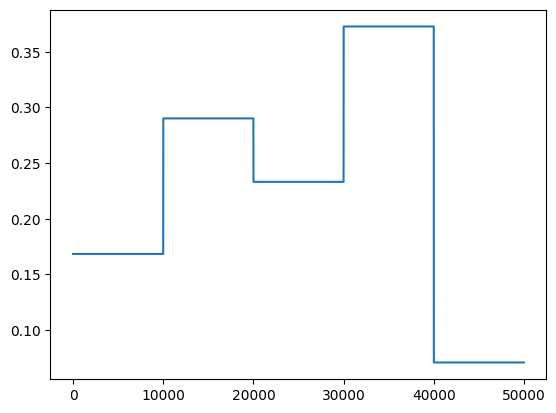

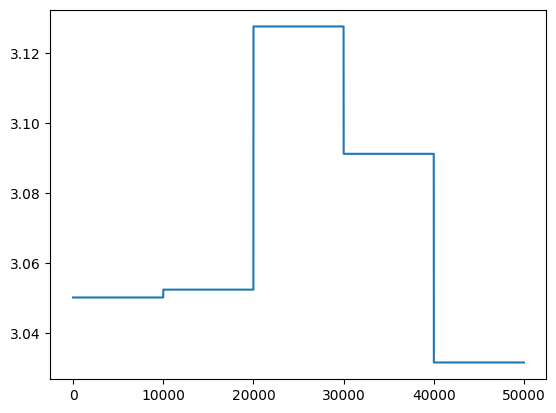

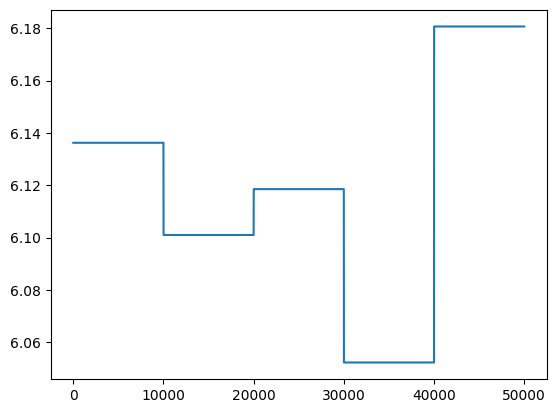

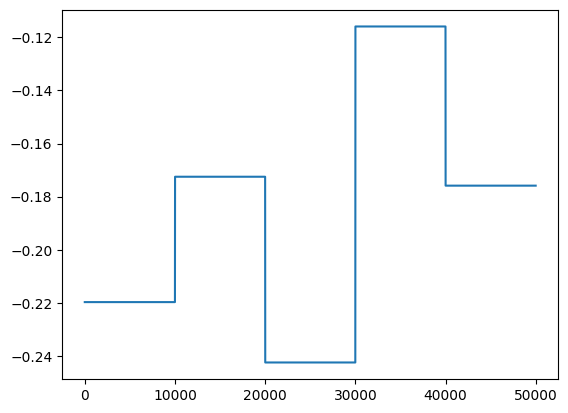

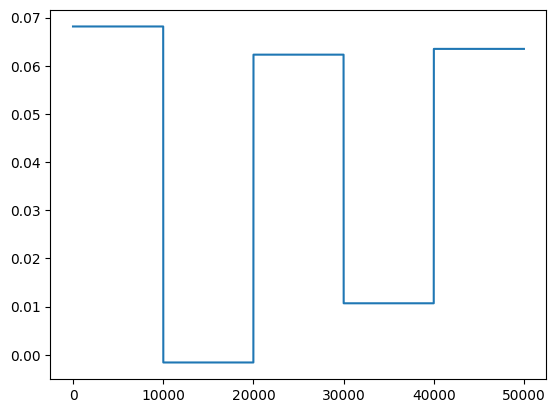

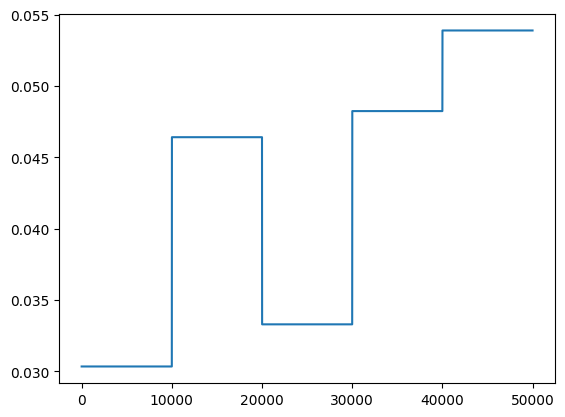

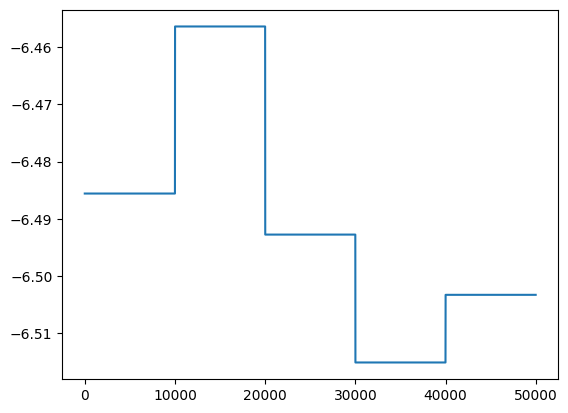

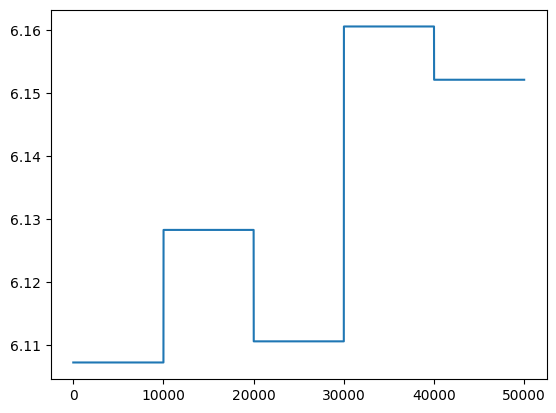

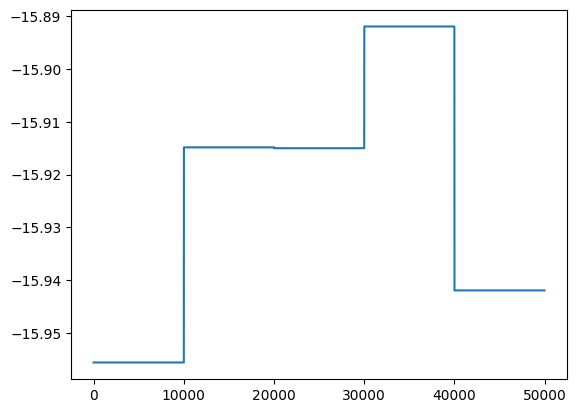

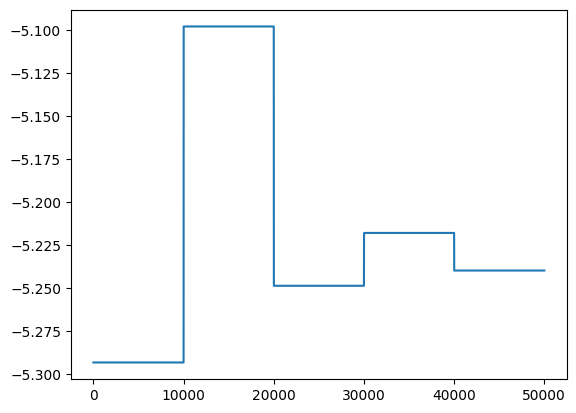

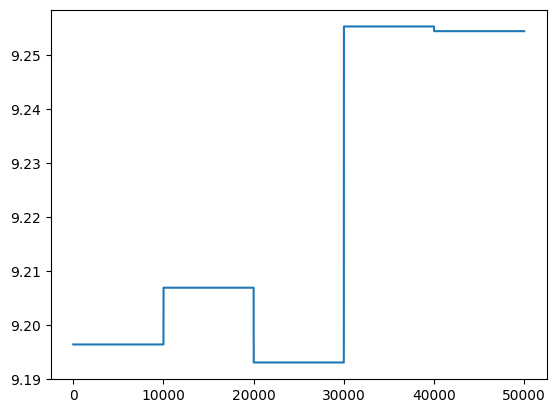

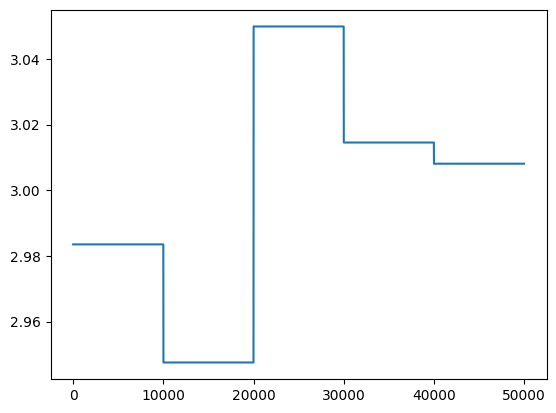

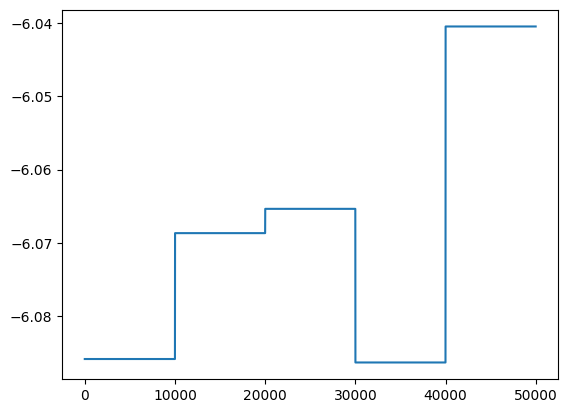

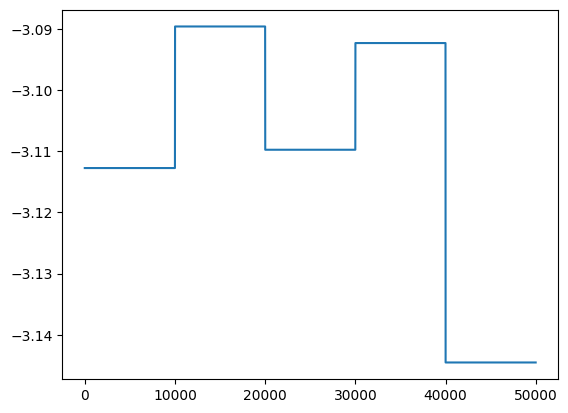

In [ ]:
param_arr = np.array(param_list_epoch).transpose()
for pa in param_arr:
    plt.plot(range(len(pa)), pa)
    plt.show()

In [ ]:
print(ideal_data[0])

(array([[3.9369   , 2.3587308],
       [1.3379747, 0.4096871],
       [4.832699 , 0.9261413],
       [1.4562938, 5.1695156],
       [2.5560277, 2.6868052]], dtype=float32), tensor([ 0.0428+0.0238j, -0.0086+0.1622j, -0.0249-0.0359j,  0.0707-0.1264j,
        -0.0430+0.0059j, -0.0803-0.1195j,  0.0367+0.0122j,  0.0172+0.1272j,
         0.0307-0.0235j,  0.1149+0.0573j, -0.0339+0.0067j, -0.0694-0.0911j,
        -0.0092+0.0331j, -0.1120+0.0206j,  0.0204-0.0228j,  0.0977+0.0276j,
        -0.0317-0.1122j,  0.2882-0.2579j, -0.0188+0.1022j, -0.3321+0.0929j,
         0.0822+0.0626j, -0.0668+0.3363j, -0.0411-0.0825j,  0.1858-0.2427j,
        -0.0913-0.0124j, -0.0963-0.2903j,  0.0682+0.0458j, -0.0372+0.2701j,
         0.0713-0.0399j,  0.2228+0.1544j, -0.0727+0.0039j, -0.1175-0.2112j],
       dtype=torch.complex128))
